In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [2]:
# Import libraries
import pandas as pd
from datasets import load_dataset
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import precision_recall_curve

# Load the IMDb dataset
dataset = load_dataset('imdb')

# Convert to DataFrame
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
# Combine train and test for preprocessing
df = pd.concat([df_train, df_test])

# Explore the dataset
print(df.head())
print(df.info())
print(df.describe())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
              label
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Preprocess the data
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['text'] = df['text'].apply(preprocess_text)

# Split data back into training and testing sets
X_train = df_train['text']
y_train = df_train['label']
X_test = df_test['text']
y_test = df_test['label']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.88
F1 Score: 0.88
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [6]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Grid Search for hyperparameter tuning
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Train the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best, average='weighted')

print(f'Best Accuracy: {best_accuracy:.2f}')
print(f'Best F1 Score: {best_f1:.2f}')
print(classification_report(y_test, y_pred_best))

Best Parameters: {'C': 1, 'solver': 'lbfgs'}
Best Accuracy: 0.88
Best F1 Score: 0.88
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



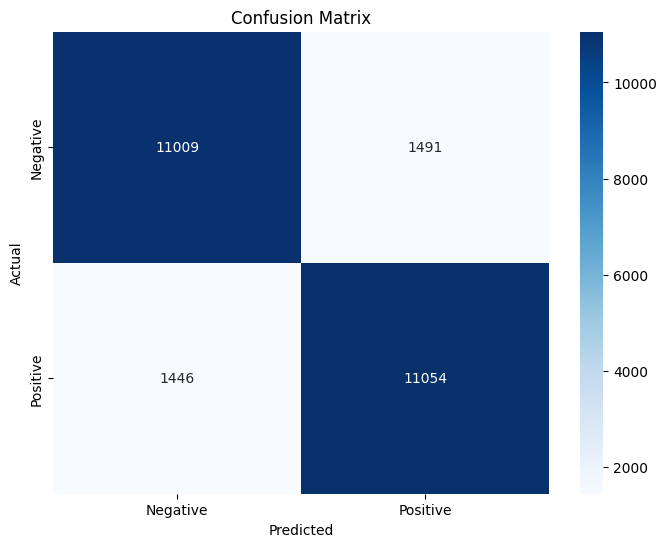

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###Class Distribution: Shows the count of positive and negative reviews in the dataset.

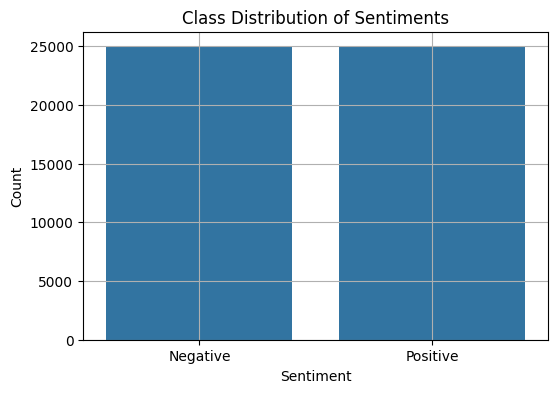

In [8]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'])
plt.title('Class Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.grid(True)
plt.show()

###Top Words in Positive and Negative Reviews: Displays the most common words in positive and negative reviews using word clouds.

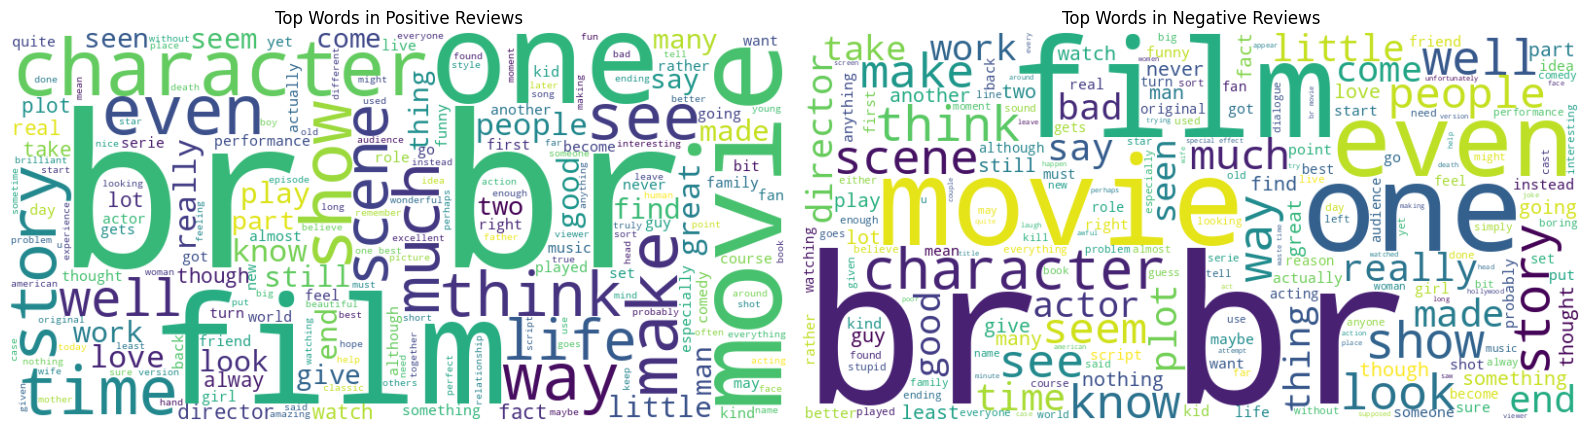

In [9]:
# Combine all positive and negative reviews
positive_text = ' '.join(df[df['label'] == 1]['text'])
negative_text = ' '.join(df[df['label'] == 0]['text'])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Top Words in Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Top Words in Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()

###Feature Importance: Shows the most important features (words) for the model, indicating which words contribute most to predicting positive and negative sentiments.

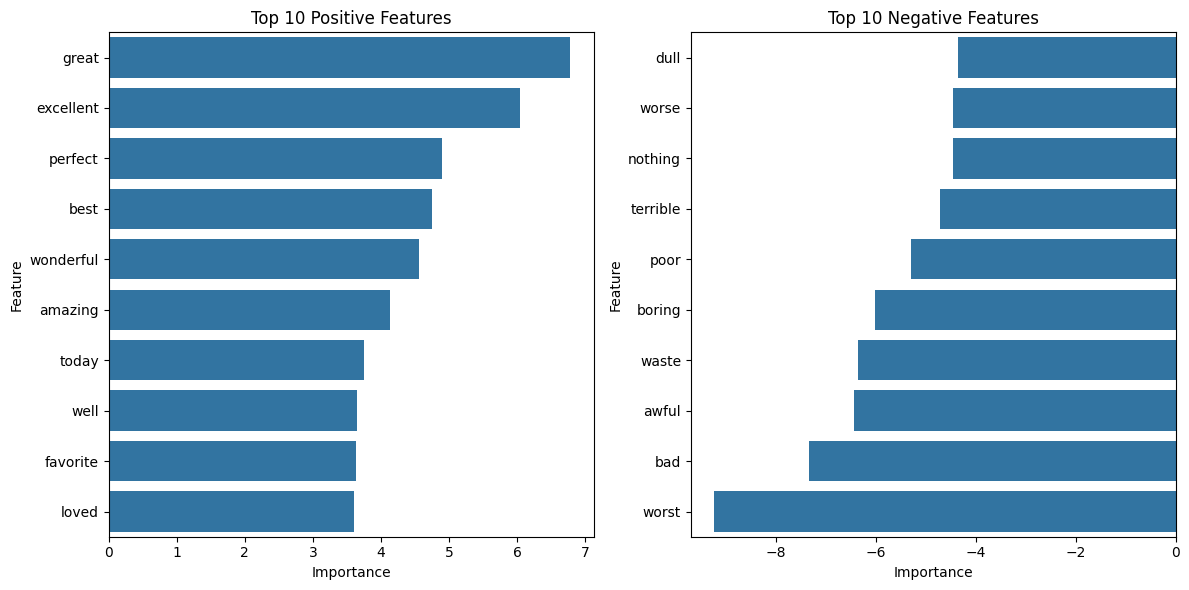

In [11]:
# Get feature importance
importance = best_model.coef_[0]
feature_names = vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Top positive and negative features
top_positive_features = importance_df.head(10)
top_negative_features = importance_df.tail(10)

# Plot feature importance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=top_positive_features, x='importance', y='feature')
plt.title('Top 10 Positive Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
sns.barplot(data=top_negative_features, x='importance', y='feature')
plt.title('Top 10 Negative Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

###Precision-Recall Curve: Helps evaluate the performance of the model in terms of precision and recall.

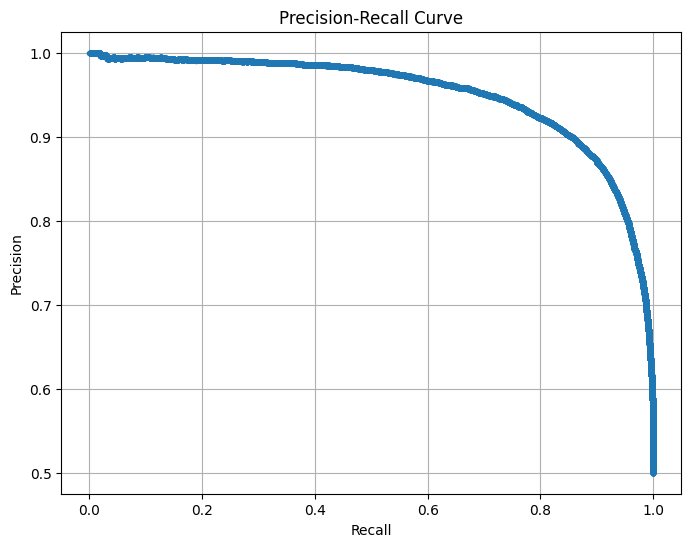

In [12]:
# Get prediction probabilities
y_probs = best_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()